In [8]:
import tensorflow as tf
import time
from datetime import timedelta
import math
import numpy as np
import os
import glob
import sys
import scipy.misc
from scipy.ndimage import imread
import timeit

In [59]:
def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    def getid(s):
        return int(''.join(c for c in s[3:] if c.isdigit()))
        
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort(key=getid)
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)
        

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    One-hot encoding converts categorical labels to binary values
    """
    y_one_hot = np.zeros((num_classes, y.shape[0]))
    y_one_hot[y, range(y.shape[0])] = 1
    return y_one_hot

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    print(os.listdir())
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1 
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)
    
def get_batch(X, y, batch_size):
    """
    Return minibatch of samples and labels
  
    :param X, y: samples and corresponding labels
    :parma batch_size: minibatch size
    :returns: (tuple) X_batch, y_batch
    """
    # Random indices for the samples

    indices = np.random.randint(y.shape[0]-1, size= batch_size)

    X_batch = X[indices, :]
    y_batch = y[indices, :]
  
    return X_batch, y_batch

# Load the data
data_root_path = 'HW2_data_t/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
y_train = one_hot(y_train).T
X_train = X_train.T
X_train = (X_train - np.mean(X_train,axis=0)) / np.std(X_train,axis=0) # Normalize data 
X_train = X_train.reshape(51,32,32,3)

# Loading test data 
X_test = get_images(data_root_path + 'test').T

print("Data loading done.")
print(X_train.shape)
print(y_train.shape)

['.DS_Store', '.ipynb_checkpoints', '__pycache__', 'aug_data', 'cat.22.jpg', 'cat_dog', 'cifar10-hw1', 'CNN (1).ipynb', 'CNN.ipynb', 'CNN_updated.ipynb.txt', 'data_size_hw2.py', 'dataset.py', 'Example of NN.ipynb', 'HW # 1.zip', 'HW 1.pdf', 'HW1(1).ipynb', 'HW1-data.tar', 'HW1-uni.ipynb', 'HW2_data', 'HW2_data_t', 'Hw2tests.ipynb', 'HW_1', 'HW_2.ipynb', 'Img_Aug.ipynb', 'img_aug1.ipynb', 'import tensorflow as tf', 'NOTES', 'notes_on_backprop.pdf', 'predict.py', 'Sample-NN from scratch.ipynb', 'TDozat-ICLR2016.pdf', 'test_submit.csv', 'TF.ipynb', 'tf_img_classifier.ipynb', 'tfbasics-Copy1.ipynb', 'train_hw2.py', 'train_hw2_2.ipynb', 'train_hw2_2.py', 'Trials # 3.ipynb', 'trials 4.ipynb', 'Trials HW ## 1 DL 2.ipynb', 'Trials HW#1 DL.ipynb', 'Untitled.ipynb']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Data loading done.
(51, 32, 32, 3)
(51, 10)


Populating the interactive namespace from numpy and matplotlib


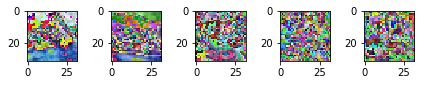

In [60]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

%pylab inline
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i])
    plt.tight_layout()

plt.show()

In [61]:
X_train = X_train.reshape(51,32,32,3)
X_imgs = X_train
IMAGE_SIZE = 32
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data
	
# Produce each image at scaling of 90%, 75% and 60% of original image.
scaled_imgs = central_scale_images(X_imgs, [0.90, 0.75, 0.60])

In [62]:
print(scaled_imgs.shape)
N = 3
y_train = np.vstack([y_train]*N)
print(y_train.shape)

(153, 32, 32, 3)
(153, 10)


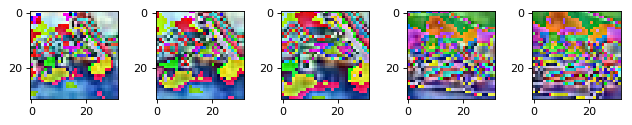

In [50]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(scaled_imgs[i])
    plt.tight_layout()

plt.show()

# Translation:
We would like our network to recognize the object present in any part of the image. Also, the object can be present partially in the corner or edges of the image. For this reason, we shift the object to various parts of the image. This may also result in addition of a background noise. The code snippet shows translating the image at four sides retaining 80 percent of the base image.

In [45]:
from math import ceil, floor

def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), 
				    dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], \
			 w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr
	
translated_imgs = translate_images(scaled_imgs)


In [46]:
translated_imgs.shape

(612, 32, 32, 3)

In [63]:
N = 4
y_train = np.vstack([y_train]*N)
print(y_train.shape)

(612, 10)


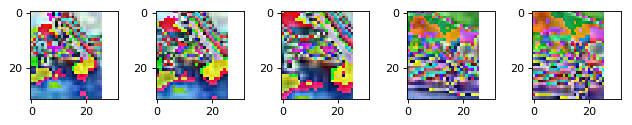

In [64]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(translated_imgs[i])
    plt.tight_layout()

plt.show()

# Rotation (at 90 degrees):
The network has to recognize the object present in any orientation. Assuming the image is square, rotating the image at 90 degrees will not add any background noise in the image.

In [76]:
def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate
	
rotated_imgs = rotate_images(translated_imgs)

In [77]:
rotated_imgs.shape

(1836, 32, 32, 3)

In [67]:
N = 3
y_train = np.vstack([y_train]*N)
print(y_train.shape)

(1836, 10)


# Rotation (at finer angles):
Depending upon the requirement, there maybe a necessity to orient the object at minute angles. However problem with this approach is, it will add background noise. If the background in image is of a fixed color (say white or black), the newly added background can blend with the image. However, if the newly added background color doesn’t blend, the network may consider it as to be a feature and learn unnecessary features.

In [78]:
from math import pi

def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 3))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * pi / 180  # Convert to radian
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate
	
# Start rotation at -90 degrees, end at 90 degrees and produce totally 14 images
rotated_imgs = rotate_images(rotated_imgs, -90, 90, 14)

In [80]:
print(rotated_imgs.shape)


(25704, 32, 32, 3)


In [82]:
N = 14
y_train = np.vstack([y_train]*N)
print(y_train.shape)

(25704, 10)
